In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import joblib
import matplotlib.pyplot as plt
import time

device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(device)

now = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

cuda


In [2]:
# 선택된 피처 리스트
input_features = [
    "high_price",
    "low_price",
    "trade_price",
    "candle_acc_trade_volume",
    "rsi_14",
    "macd_histogram",

    # "atr_14",
    # "stoch_k",
    # "stoch_d",
]

input_size = len(input_features)
hidden_size = 100
num_layers = 2
output_size = 1
learning_rate = 0.00025
num_epochs = 200 # 100
batch_size = 32

print("hidden_size:", hidden_size)
print("num_layers:", num_layers)
print("num_epochs:", num_epochs)
print("batch_size:", batch_size)

hidden_size: 100
num_layers: 2
num_epochs: 200
batch_size: 32


In [3]:
filename = "KRW-XRP-5m-full"

# npy 파일 불러오기
X = np.load(f"../../preprocessed/2025-01-14/{filename}-X.npy")
y = np.load(f"../../preprocessed/2025-01-14/{filename}-y.npy")

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Numpy 배열을 Tensor로 변환
# X_train = torch.from_numpy(X).type(torch.FloatTensor).to(device)
# y_train = torch.from_numpy(y).type(torch.FloatTensor).to(device)

In [4]:
# 데이터셋 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 데이터셋 생성
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
for X_batch, y_batch in train_loader:
    if torch.isnan(X_batch).any() or torch.isnan(y_batch).any():
        print("NaN detected in training data batch")
        break

for X_batch, y_batch in test_loader:
    if torch.isnan(X_batch).any() or torch.isnan(y_batch).any():
        print("NaN detected in test data batch")
        break

In [6]:
# 조기 종료 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # 초기 은닉 상태와 셀 상태 설정 (입력 텐서의 디바이스 사용)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        
        # LSTM 통과
        out, _ = self.lstm(x, (h0, c0))
        
        # 마지막 타임스텝의 출력만 사용
        out = out[:, -1, :]
        
        # Fully connected 레이어 통과
        out = self.fc(out)
        return out

In [7]:
print("Available GPUs:", torch.cuda.device_count())

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}:")
    print("  Name:", torch.cuda.get_device_name(i))
    print("  Allocated memory:", torch.cuda.memory_allocated(i) / 1e9, "GB")
    print("  Cached memory:", torch.cuda.memory_reserved(i) / 1e9, "GB")
    print("  Utilization:", torch.cuda.max_memory_allocated(i) / torch.cuda.get_device_properties(i).total_memory * 100, "%")


print("Current GPU in use:", torch.cuda.current_device())

Available GPUs: 4
GPU 0:
  Name: NVIDIA RTX A6000
  Allocated memory: 0.0 GB
  Cached memory: 0.0 GB
  Utilization: 0.0 %
GPU 1:
  Name: NVIDIA RTX A6000
  Allocated memory: 0.0 GB
  Cached memory: 0.0 GB
  Utilization: 0.0 %
GPU 2:
  Name: NVIDIA RTX A6000
  Allocated memory: 0.0 GB
  Cached memory: 0.0 GB
  Utilization: 0.0 %
GPU 3:
  Name: NVIDIA RTX A6000
  Allocated memory: 0.0 GB
  Cached memory: 0.0 GB
  Utilization: 0.0 %
Current GPU in use: 0


In [8]:
model = LSTMModel(input_size, hidden_size, num_layers).to(device)


# 여러 GPU 사용 설정
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    print("yep")

current_device = next(model.parameters()).device
print(f"모델이 사용 중인 디바이스: {current_device}")

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

yep
모델이 사용 중인 디바이스: cuda:0


In [9]:
for name, param in model.named_parameters():
    if torch.isnan(param).any():
        print(f"NaN detected in parameter: {name}")

In [10]:
from torch.nn.utils import clip_grad_norm_

# 조기 종료 초기화
early_stopping = EarlyStopping(patience=10, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# 모델 훈련
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)

        # 출력에 NaN이 있는지 확인
        if torch.isnan(outputs).any():
            print(f"Epoch {epoch+1}: NaN detected in outputs during training")
            break

        loss = criterion(outputs, y_batch)

        # 손실에 NaN이 있는지 확인
        if torch.isnan(loss).any():
            print(f"Epoch {epoch+1}: NaN detected in loss during training")
            break

        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)  # 그레이디언트 클리핑
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # 테스트 손실 계산
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            
            # 출력에 NaN이 있는지 확인
            if torch.isnan(outputs).any():
                print(f"Epoch {epoch+1}: NaN detected in outputs during evaluation")
                continue  # NaN이 있는 경우 건너뜀
            
            loss = criterion(outputs, y_batch)
            
            # 손실에 NaN이 있는지 확인
            if torch.isnan(loss).any():
                print(f"Epoch {epoch+1}: NaN detected in loss during evaluation")
                continue
            
            test_loss += loss.item() * X_batch.size(0)
    
    test_loss /= len(test_loader.dataset)

    end_time = time.time()  # 에포크 종료 시간 기록
    epoch_time = end_time - start_time  # 소요 시간 계산
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.12f}, Test Loss: {test_loss:.12f}, Time: {epoch_time:.2f}s, Current Time: {time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())}')
    
    # 조기 종료 조건 확인
    early_stopping(test_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    # 학습률 스케줄러 업데이트 (선택 사항)
    scheduler.step(test_loss)

/home/dowonseo/anaconda3/envs/upbit/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/200], Train Loss: 0.000027895666, Test Loss: 0.000010360166, Time: 203.41s, Current Time: 2025-01-16 06:50:00
Epoch [2/200], Train Loss: 0.000001489222, Test Loss: 0.000016381815, Time: 194.55s, Current Time: 2025-01-16 06:53:14
EarlyStopping counter: 1 out of 10
Epoch [3/200], Train Loss: 0.000001136742, Test Loss: 0.000035067994, Time: 202.24s, Current Time: 2025-01-16 06:56:37
EarlyStopping counter: 2 out of 10
Epoch [4/200], Train Loss: 0.000001032939, Test Loss: 0.000047226046, Time: 198.27s, Current Time: 2025-01-16 06:59:55
EarlyStopping counter: 3 out of 10
Epoch [5/200], Train Loss: 0.000000971227, Test Loss: 0.000055336325, Time: 199.94s, Current Time: 2025-01-16 07:03:15
EarlyStopping counter: 4 out of 10
Epoch [6/200], Train Loss: 0.000000781951, Test Loss: 0.000011758916, Time: 199.09s, Current Time: 2025-01-16 07:06:34
EarlyStopping counter: 5 out of 10
Epoch [7/200], Train Loss: 0.000000782001, Test Loss: 0.000025615733, Time: 197.00s, Current Time: 2025-01-16 0

In [11]:
# 모델 저장

model_filename = f'{filename}-lr{learning_rate}_bs{batch_size}-epochs{num_epochs}-hs{hidden_size}_nl{num_layers}.pth'
torch.save(model.state_dict(), f"../../model/2025-01-14/{filename}.pth")

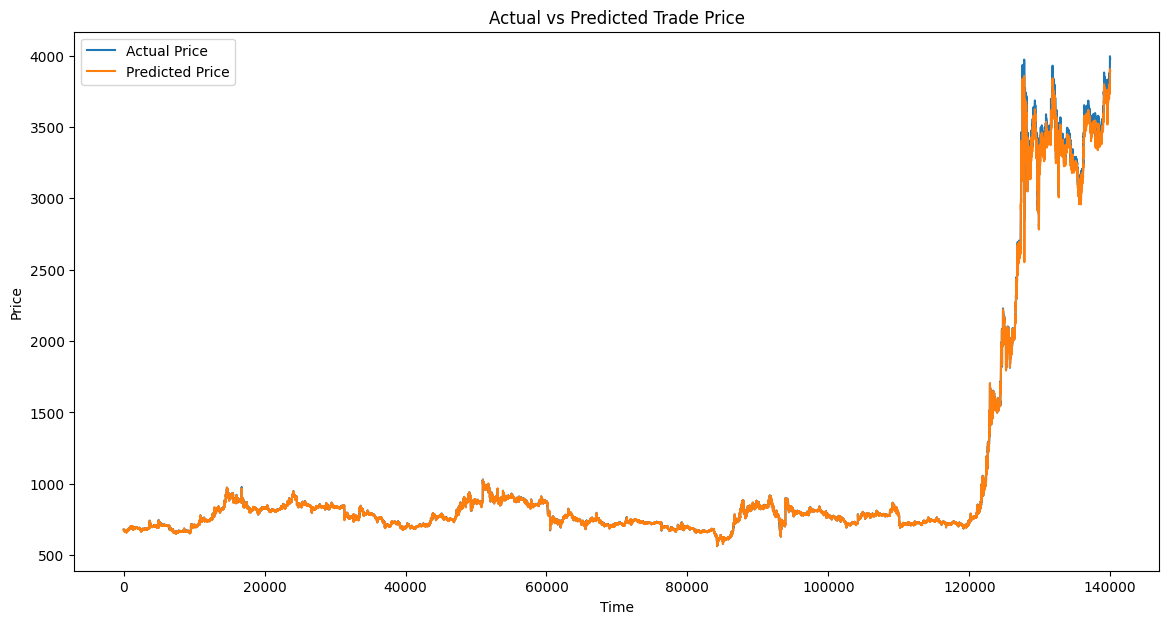

MAE: 5.1412
MSE: 201.4837
RMSE: 14.1945
R²: 0.9997


In [12]:
# 모델 평가 및 시각화
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        
        # 출력에 NaN이 있는지 확인
        if torch.isnan(outputs).any():
            print("NaN detected in model outputs during evaluation")
            continue  # NaN이 있는 경우 건너뜀
        
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

predictions = np.concatenate(predictions).reshape(-1, 1)
actuals = np.concatenate(actuals).reshape(-1, 1)

# 스케일러 로드 (올바른 경로 사용)
scaler_target = joblib.load(f"../../pickles/2025-01-14/{filename}-scaler_target.pkl")

# 스케일 되돌리기
try:
    predictions_original = scaler_target.inverse_transform(predictions)
    actuals_original = scaler_target.inverse_transform(actuals)
except ValueError as e:
    print(f"Inverse transform error: {e}")
    # 추가적인 디버깅 필요

# 시각화
plt.figure(figsize=(14,7))
plt.plot(actuals_original, label='Actual Price')
plt.plot(predictions_original, label='Predicted Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Trade Price')
plt.show()

# 추가 평가지표
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(actuals_original, predictions_original)
mse = mean_squared_error(actuals_original, predictions_original)
rmse = np.sqrt(mse)
r2 = r2_score(actuals_original, predictions_original)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

In [13]:
print(predictions.shape)  # 예상: (n_samples, 1)
print(actuals.shape)      # 예상: (n_samples, 1)

(139988, 1)
(139988, 1)


In [14]:
for i in range(10):
    print(f"Actual: {actuals_original[i][0]}, Predicted: {predictions_original[i][0]}")

Actual: 679.0, Predicted: 679.4645385742188
Actual: 679.0, Predicted: 678.8494873046875
Actual: 679.0, Predicted: 678.5032958984375
Actual: 679.0, Predicted: 678.668212890625
Actual: 679.0, Predicted: 678.1808471679688
Actual: 679.0, Predicted: 678.6617431640625
Actual: 678.0, Predicted: 678.1626586914062
Actual: 678.0, Predicted: 677.6893920898438
Actual: 678.0, Predicted: 677.8558349609375
Actual: 679.0, Predicted: 677.7327880859375


In [15]:
print(np.isnan(X_train).sum(), np.isnan(y_train).sum())
print(np.isnan(X_test).sum(), np.isnan(y_test).sum())

0 0
0 0
